In [3]:
#imports and cwd
import numpy as np
from cv2 import cv2
import os
import matplotlib.pyplot as plt
import pickle
import scipy.optimize as opt
import scipy.stats as sts
import math
import vifida as vif
import pygad as ga

os.chdir("\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration")

In [4]:
#load calibration
cFile = open('M0.cal', 'rb')
[ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo] = pickle.load(cFile)
cFile.close()


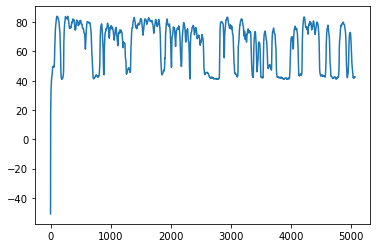

In [5]:
#Create a set of instructions from audio with the naive approach
slowFactor = 4
framerate = 25

wavfilepath = "\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\sol.WAV"
#framerate*slowfactor accounts for the fact of recording at a lower speed
#it is only used here, from this point we work at the actual recording speed
sensed, samplerate, duration = vif.wavToSensed(wavfilepath,framerate*slowFactor,forceMono=True)

plt.plot(sensed)


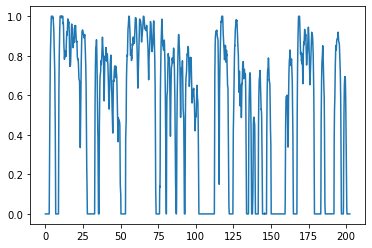

In [6]:
#adjust the variables to get nice dinamycs
drive = vif.sensedToFuzzy(sensed,thres=42,k=1.15)
time = np.linspace(0,len(drive)-1,len(drive),dtype="float64")/framerate

plt.plot(time,drive)

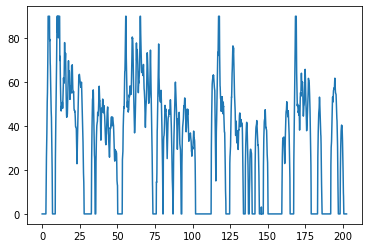

In [7]:
#visualise it angularly
ideal = signal2cresc(drive)*90

plt.plot(time,ideal)

Number of speeds unreachable:
153
Fraction unreachable:
0.0302


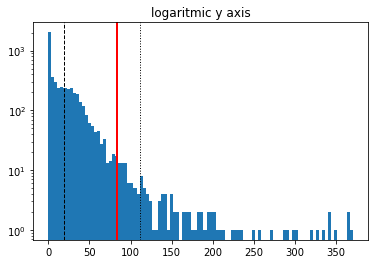

In [8]:
#study speed distributions
idealSpeeds=np.zeros( (len(ideal)-1,1) )

for i in range(len(idealSpeeds)):
    idealSpeeds[i]=(ideal[i+1]-ideal[i])*framerate

absIS=abs(idealSpeeds)

#compare to reachable speeds
absInputs=np.linspace(1,14,14)
absSpeeds=absInputs*ieq

plt.hist(absIS,bins = 100)
plt.axvline(absIS.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(absSpeeds.max(), color='red', linestyle='-', linewidth=2)
plt.axvline(absIS.mean()+3*absIS.std(), color='k', linestyle='dotted', linewidth=1)
plt.yscale('log')
plt.title("logaritmic y axis")

print("Number of speeds unreachable:")
print(sum(absIS>absSpeeds.max())[0])
print("Fraction unreachable:")
print(round((sum(absIS>absSpeeds.max())/len(absIS))[0],4))


Typical angular error:
5.4
Max angular error:
30.9


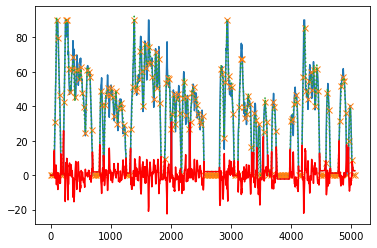

In [17]:
#fisrt approach: fixed number of movements N
N=200
orders=np.zeros((N+1,2))

#Inicialization
ind=np.linspace(0,len(ideal)-1,N+1,dtype='int')
controlIdeal=ideal[ind]
controlTime=time[ind]

for i in range(N):
    """ thisInd = ind[i]
    nextInd = ind[i+1]
    thisTime = (nextInd*1.0-thisInd*1.0)/framerate """
    thisTime = controlTime[i+1]-controlTime[i]

    #speed
    """ orders[i,0]=(ideal[nextInd]-ideal[thisInd])/thisTime """
    orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
    orders[i,0]=round(orders[i,0]/ieq)
    if orders[i,0] > 14:
        orders[i,0] = 14
    elif orders[i,0] < -14:
        orders[i,0] = -14

    #steps
    if orders[i,0] == 0:
        orders[i,1]=round(thisTime*1000)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]
    else :
        orders[i,1]=abs(orders[i,0]*ieq)*thisTime
        orders[i,1]=round(orders[i,1]/seq)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

#Reconstruction visualization:
rebuilt=np.zeros_like(ideal)
thisInd=0
for i in range(orders.shape[0]):
    thisI=orders[i,0]
    thisS=orders[i,1]
    if thisI==0:
        if thisS==0:
            break
        else: #if v==0, s are waiting time in ms
            nextInd= round(thisInd+thisS/1000*framerate).astype('int')
            interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
    else:
        thisTime= thisS*seq / (abs(thisI)*ieq)
        #print(thisTime)
        nextInd= thisInd + thisTime*framerate
        nextInd= round(nextInd).astype('int')
        interval=np.linspace(rebuilt[thisInd],
        rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
        nextInd-thisInd+1)
    
    rebuilt[thisInd:nextInd+1]=interval.flatten()
    thisInd=nextInd


plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

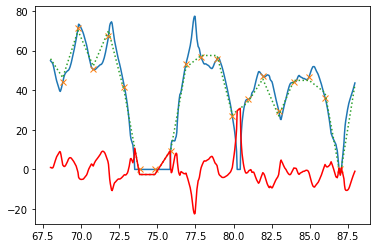

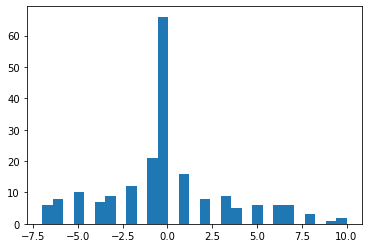

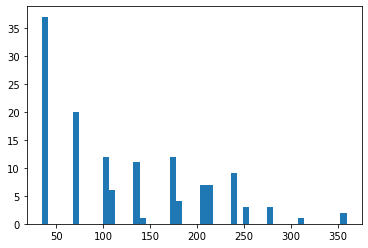

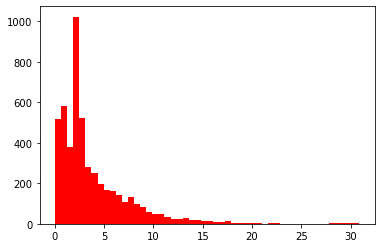

In [18]:
#zoom the first 20 seconds
aux1=1700
aux2=2200
plt.plot(time[aux1:aux2],ideal[aux1:aux2])
plt.plot(time[ind[ (ind>aux1)&(ind<aux2) ]],ideal[ind[ (ind>aux1)&(ind<aux2) ]],linestyle='',marker='x')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2],linestyle=':')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2]-ideal[aux1:aux2],color='red')
plt.show()

#velocity distribution
plt.hist(orders[:,0],bins=29)
plt.show()

#step number distribution
plt.hist(orders[orders[:,0]!=0,1],bins=50)
plt.show()

#error distribution
plt.hist(abs(rebuilt-ideal),bins=50,color='red')
plt.show()


In [2]:
def general_CP(cp,ideal,time,framerate=25):
    """     print("len(cp): ",len(cp))
    print("min(cp): ",min(cp))
    print("max(cp): ",max(cp))
    print("framerate: ",framerate) """

    N=len(cp)+1
    #Setup:
    orders=np.zeros((N+1,2))
    ind=np.append(0,np.sort(cp))
    ind=np.append(ind,len(ideal)-1)

    controlIdeal=ideal[ind]
    controlTime=time[ind]

    try:
        for i in range(N):
            thisTime = controlTime[i+1]-controlTime[i]

            #speed
            orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
            orders[i,0]=round(orders[i,0]/ieq)
            if orders[i,0] > 14:
                orders[i,0] = 14
            elif orders[i,0] < -14:
                orders[i,0] = -14

            #steps
            if orders[i,0] == 0:
                orders[i,1]=round(thisTime*1000)
                #update control point
                controlIdeal[i+1]=controlIdeal[i]
            else :
                orders[i,1]=abs(orders[i,0]*ieq)*thisTime
                orders[i,1]=round(orders[i,1]/seq)
                #update control point
                controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

        #Reconstruction visualization:
        rebuilt=np.zeros_like(ideal)
        thisInd=0
        for i in range(orders.shape[0]):
            thisI=orders[i,0]
            thisS=orders[i,1]
            if thisI==0:
                if thisS==0:
                    break
                else: #if v==0, s are waiting time in ms
                    nextInd= round(thisInd+thisS/1000*framerate).astype('int')
                    interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
            else:
                thisTime= thisS*seq / (abs(thisI)*ieq)
                #print(thisTime)
                nextInd= thisInd + thisTime*framerate
                nextInd= round(nextInd).astype('int')
                interval=np.linspace(rebuilt[thisInd],
                rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
                nextInd-thisInd+1)
        
            rebuilt[thisInd:nextInd+1]=interval.flatten()
            thisInd=nextInd
    except:
        print("debugging")
        print("thisInd: ", thisInd)
        print("nextInd: ", nextInd)
        print("i: ",i)
        print(ind[:50])
        return 0
        
    #Return the inverse of MSE (error):
    return 1/np.mean(np.power((rebuilt-ideal),2))

#test approach
test=np.linspace(1,len(ideal)-2,N-1,dtype='int')
general_CP(test,ideal,time)


NameError: name 'np' is not defined

In [53]:
#Control Point Optimization (CPO) using a genetic/evolutionary approach
N=200 #number of control points fixed

def fitness_CPO(cp,cp_idx):
    return general_CP(cp,ideal,time)

fitness_CPO(test,None)

fitness_function = fitness_CPO

num_generations = 50
num_parents_mating = 10

sol_per_pop = 100
num_genes = (N-1)               #<-------------------

init_range_low = 2              #<-------------------
init_range_high = len(ideal)-2  #<-------------------

gene_type=int

parent_selection_type = "rank"
keep_parents = 8

crossover_type = "single_point"

mutation_type = "random"
mutation_probability=0.3
mutation_percent_genes =20
gene_space=np.linspace(init_range_low,init_range_high,init_range_high-init_range_low+1,dtype=int)

allow_duplicate_genes=False

def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

        parent1 = np.sort(parent1)
        parent2 = np.sort(parent2)

        #random_split_point = numpy.random.choice(range(offspring_size[0]))
        #parent1[random_split_point:] = parent2[random_split_point:]

        parent1=((parent1+parent2)/2).astype(int)

        offspring.append(parent1)

        idx += 1

    return numpy.array(offspring)

def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("MSE of the best solution :", math.sqrt(1/ga_instance.best_solution()[1]))

In [54]:
ga_instance = ga.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes, 
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       gene_type=int,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=allow_duplicate_genes,
                       callback_generation=callback_gen,
                       gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

Generation :  1
MSE of the best solution : 8.273039241873187
Generation :  2
MSE of the best solution : 8.264688363083994
Generation :  3
MSE of the best solution : 7.805968435847933
Generation :  4
MSE of the best solution : 7.673524328960686
Generation :  5
MSE of the best solution : 7.673524328960686
Generation :  6
MSE of the best solution : 7.6321497972877275
Generation :  7
MSE of the best solution : 7.6321497972877275
Generation :  8
MSE of the best solution : 7.6321497972877275
Generation :  9
MSE of the best solution : 7.6321497972877275
Generation :  10
MSE of the best solution : 7.6321497972877275
Generation :  11
MSE of the best solution : 7.6321497972877275
Generation :  12
MSE of the best solution : 7.405760597329017
Generation :  13
MSE of the best solution : 7.405760597329017
Generation :  14
MSE of the best solution : 7.405760597329017
Generation :  15
MSE of the best solution : 7.405760597329017
Generation :  16
MSE of the best solution : 7.405760597329017
Generation 

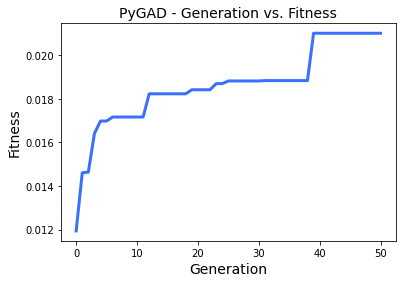

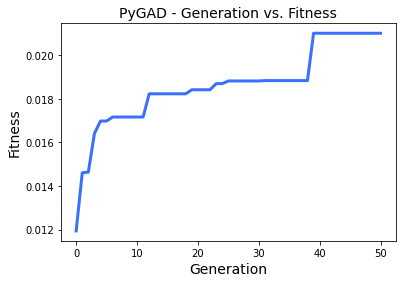

In [55]:
ga_instance.plot_fitness()

Typical angular error:
6.9
Max angular error:
34.6


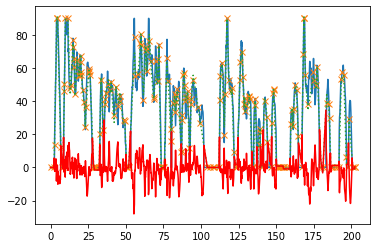

In [56]:
ind=np.append(0,np.sort(solution))
ind=np.append(ind,len(ideal)-1)
controlIdeal=ideal[ind]
controlTime=time[ind]

orders=np.zeros((N+1,2))

for i in range(N):
    """ thisInd = ind[i]
    nextInd = ind[i+1]
    thisTime = (nextInd*1.0-thisInd*1.0)/framerate """
    thisTime = controlTime[i+1]-controlTime[i]

    #speed
    """ orders[i,0]=(ideal[nextInd]-ideal[thisInd])/thisTime """
    orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
    orders[i,0]=round(orders[i,0]/ieq)
    if orders[i,0] > 14:
        orders[i,0] = 14
    elif orders[i,0] < -14:
        orders[i,0] = -14

    #steps
    if orders[i,0] == 0:
        orders[i,1]=round(thisTime*1000)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]
    else :
        orders[i,1]=abs(orders[i,0]*ieq)*thisTime
        orders[i,1]=round(orders[i,1]/seq)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

#Reconstruction visualization:
rebuilt=np.zeros_like(ideal)
thisInd=0
for i in range(orders.shape[0]):
    thisI=orders[i,0]
    thisS=orders[i,1]
    if thisI==0:
        if thisS==0:
            break
        else: #if v==0, s are waiting time in ms
            nextInd= round(thisInd+thisS/1000*framerate).astype('int')
            interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
    else:
        thisTime= thisS*seq / (abs(thisI)*ieq)
        #print(thisTime)
        nextInd= thisInd + thisTime*framerate
        nextInd= round(nextInd).astype('int')
        interval=np.linspace(rebuilt[thisInd],
        rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
        nextInd-thisInd+1)
    
    rebuilt[thisInd:nextInd+1]=interval.flatten()
    thisInd=nextInd


plt.plot(time,ideal)
plt.plot(time[ind],ideal[ind],linestyle='',marker='x')
plt.plot(time,rebuilt,linestyle=':')
plt.plot(time,rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

In [15]:
#Create instructions
""" small_stepper.setSpeed(1.0000);
small_stepper.step(0);
delay(2000); """

#make sure the file is empty
f = open('instructions.txt', 'w')
f.close()

#write instructions
f = open('instructions.txt', 'a')

for i in range(len(orders)):
    if orders[i,0]!=0:
        f.write("small_stepper.setSpeed(")
        f.write(str(int(abs(orders[i,0]))))
        f.write(");\n")
        f.write("small_stepper.step(")
        f.write(str(int( math.copysign(orders[i,1],orders[i,0]) )))
        f.write(");\n")
    else:
        if orders[i,1]==0:
            break
        else:
            f.write("delay(")
            f.write(str(int( orders[i,1] )))
            f.write(");\n")
f.close()


In [23]:
((ind[:50]+ind[:50])/3).astype(int)

array([   0,   73,  126,  162,  173,  286,  316,  364,  437,  463,  503,
        602,  830,  836,  884,  933, 1074, 1092, 1116, 1126, 1218, 1295,
       1328, 1352, 1408, 1421, 1530, 1558, 1606, 1764, 1907, 1938, 1943,
       1959, 2052, 2102, 2162, 2170, 2451, 2486, 2505, 2517, 2593, 2614,
       2708, 3063, 3088, 3113, 3243, 3268])

In [24]:
((ind[:50]+ind[:50])/6).astype(int)

array([   0,   36,   63,   81,   86,  143,  158,  182,  218,  231,  251,
        301,  415,  418,  442,  466,  537,  546,  558,  563,  609,  647,
        664,  676,  704,  710,  765,  779,  803,  882,  953,  969,  971,
        979, 1026, 1051, 1081, 1085, 1225, 1243, 1252, 1258, 1296, 1307,
       1354, 1531, 1544, 1556, 1621, 1634])